# Calculando Módulo de Young do Grafeno

* PET - Física UFRN
* Petiano: José Arthur de Luna Oliveira
* Data: 27/07/2024

$\quad$ Neste `Notebook` veremos como determinar o módulo de Young do grafeno em Dinâmica Molecular (MD), com esse fim, utilizaremos o programa `LAMMPS` pelo Python, como foi feito no `Notebook` _Deformando Nanotubo de Carbono_ [1]. Nosso objetivo é obter um valor do módulo de Young bem próximo aos encontrados na literatura. Traremos essa questão com uma abordagem didática: explicaremos como calcular esse valor e como fazer a simulação, explicando cada comando utilizado.

## Pré-requisitos

$\quad$ Para o leitor acompanhar os códigos feitos neste `Notebook` é necessário ter o `LAMMPS` e o `VMD` instalado no computador. Logo abaixo estão listados os links para fazer o download dos programas:

* [LAMMPS](https://docs.lammps.org/Install.html);
* [VMD](https://www.ks.uiuc.edu/Development/Download/download.cgi?PackageName=VMD);
* [Open MPI](https://www.open-mpi.org/software/ompi/v5.0/).

$\quad$ Além disso, recomendo que o leitor já tenha lido o `Notebook` _Deformando Nanotubo de Carbono_ [1], onde já foi explicado como usar algumas ferramentas do `VMD` que precisaremos usar neste trabalho.

### Importando Bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

### Detalhes das Bibliotecas

In [2]:
%load_ext version_information
%version_information Matplotlib, Numpy, Scipy

Software versions
Python 3.11.9 64bit [MSC v.1916 64 bit (AMD64)]
IPython 8.20.0
OS Windows 10 10.0.22631 SP0
Matplotlib 3.8.4
Numpy 1.26.4
Scipy 1.12.0
Thu Jul 25 13:46:44 2024 Hora Padrão de Buenos Aires

## 1. O Módulo de Young

$\quad$ Antes de criarmos o arquivo input, devemos saber o que é o módulo de Young e como determinamos essa propriedade. O módulo de Young é uma das propriedades mecânicas mais importantes para entendermos o comportamento elástico do material. Esta mede a rigidez de um material, em outras palavras, a capacidade do material deformar em uma dimensão e retornar à sua forma original [2, 3].

$\quad$ O módulo de Young é encontrado pela relação da tensão ou stress ($\sigma$) causado no material pela deformação ($\epsilon$) feita, essa como definida abaixo:

$$ E = \frac{\sigma}{\epsilon} \ ,$$

onde $E$ é o módulo de Young. Os outros termos devem ser determinados também, o stress é definido como está descrito abaixo

$$ \sigma = \frac{F}{A} \ ,$$

em que $F$ é a força que está deformando o material e $A$ é a área da seção transversal do material. Já a deformação deve ser determinada da seguinte forma

$$\epsilon = \frac{\Delta L}{L_0} \ ,$$

o qual $\Delta L$ é a variação do comprimento do material (esse comprimento é referente a dimensão que a deformação foi aplicada) e $L_0$ é o tamanho inicial do corpo. Os dados da deformação e stress obtemos após a simulação ser feita.

## 2. Preparativos antes de montar o input

$\quad$ Agora, após uma breve explicação sobre o módulo de Young, devemos montar o arquivo input da nossa simulação. De maneira geral, na simulação de Dinâmica Molecular, a lâmina de grafeno terá que ser deformada em uma dimensão. E para aplicar essa deformação, em vez de esticar aplicando uma força em cada ponta do grafeno, aumentaremos o tamanho da caixa, visando deformarmos o grafeno. Essa caixa deve possuir paredes periódicas. Antes de tudo, explicaremos primeiramente como funciona a caixa da simulação de paredes periódicas em Dinâmica Molecular (MD).

## 2.1 Caixa do sistema

$\quad$ Basicamente, a caixa é onde estarão todos os átomos da simulação. No entanto, em MD, quando as paredes dela são periódicas, em cada lado da caixa é como se houvesse outra espelhada. Imagine um espaço com vários átomos e dividimos esse espaço em várias caixas, em que cada uma delas possua os mesmos átomos e a mesma quantidade de átomos. Além disso, estes átomos se movem da mesma forma em todas as caixas. Portanto, teremos agora diversos sistemas atômicos, todos iguais [4]. Vale salientar que isso apenas ocorre quando configuramos as paredes da nossa simulação como periódicas. A figura abaixo ilustra o que foi dito acima.

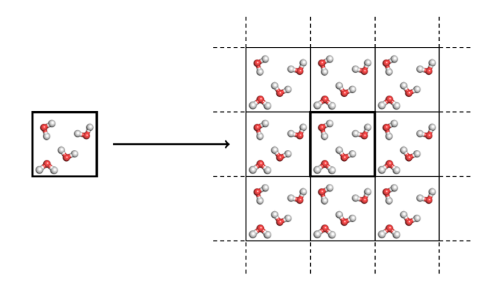

$\quad$ A caixa quanto tem extremidades periódicas, se um átomo sair do sistema pela extremidade direita, outro átomo entra no sistema pela esquerda. Isso quer dizer que o nosso sistema não perderá átomos, além disso, átomos de um sistema podem interagir com os dos outros, colidindo, se acoplando, entre outros. E essas interações são importantes para a nossa simulação.

$\quad$ Dito isto, para que o método de esticar o grafeno funcione devemos deixá-lo “infinito”. Imagine que uma lâmina de grafeno numa caixa, a qual as suas dimensões no eixo $x$ e $y$ têm quase o mesmo tamanho que os grafeno, de maneira que o grafeno consiga fazer ligações com os outros grafenos dos outros sistemas. Dessa forma, teremos um grafeno “infinito”, caso alteremos as dimensões da caixa, também alteraremos as dimensões da estrutura da mesma forma. Assim, se esticarmos a caixa da simulação no eixo $x$, o grafeno também será esticado nesse mesmo eixo.

## 2.2 Gerando a estrutura

$\quad$ Uma das coisas que devem ser feitas antes de montarmos o arquivo input é gerar a estrutura para simulação. Para isso, usaremos o programa `VMD`, inicie o programa e quando isso acontecer, abrirão três janelas: uma do prompt do `VMD`, uma será o display, nessa é possível observar a estrutura gerada, e a outra chamada `VMD main`, nela conseguimos criar, ler e salvar arquivos. 

$\quad$ Na janela `VMD main` siga o seguinte procedimento: vá em `Extensions` $\rightarrow$ `Modeling` $\rightarrow$ `Nanotube Builder`. Feito isso, abrirá uma nova janela do `VMD`, nesta conseguimos gerar a lâmina de grafeno. Para a nossa simulação, criaremos um grafeno com tamanho de $10 \ nm$ no eixo $x$ e $5 \ nm$ no eixo $y$. Após isso, no display, poderá ver a estrutura gerada, como na imagem abaixo.

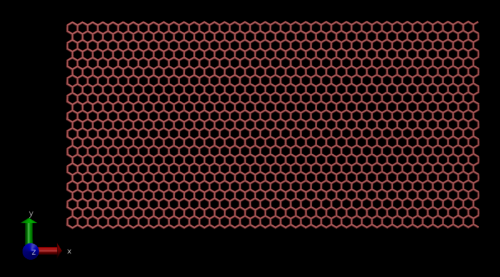

$\quad$ Feito isso, definiremos agora o tamanho da caixa. Com esse objetivo, no programa `VMD` faça o seguinte procedimento: vá `Extensions` $\rightarrow$ `Tk Console`. Em seguida, uma nova janela será aberta, no `Tk Console` é onde definiremos o tamanho da caixa, rodando as seguintes linhas de comando: `pbc box -center com` e depois `pbc set {51.3 101.3 40}`. A primeira linha de comando permite que visualizemos os limites da caixa no display, e a outra define o tamanho da caixa em cada eixo de coordenada, $x$, $y$ e $z$, respectivamente.

$\quad$ Note que a caixa possui quase as mesmas dimensões da nossa lâmina de grafeno, o valor a mais que foi colocado é para haver distância suficiente dos outros grafenos, a fim que interajam e façam ligações mutuamente, e tenhamos um grafeno “infinito”. Caso a caixa tenha as mesmas dimensões que o grafeno, a interação de repulsão com os outros sistemas será muito forte e o grafeno provavelmente irá explodir, então é necessário haver este espaçamento. Além disso, note que no eixo $z$ colocamos uma distância maior, de forma que o grafeno fique isolado dos sistemas de cima e de baixo. Pomos de forma, pois, caso tivesse distância para ter interação, então estaríamos analisando uma estrutura de grafeno com várias camadas, e neste trabalho estamos interessados em encontrar o módulo de Young do grafeno em monocamada.

$\quad$ Em seguida, feito tudo isso, agora geremos um arquivo da estrutura. Com isso, vá no prompt do `VMD`, usando o comando `cd` ponha na pasta que queira salvar, e utilizando a seguinte linha de comando `topo writelammpsdata data.grafeno charge`, este será o arquivo que o nosso input lerá para saber as posições dos átomos de carbono do nosso sistema.

## 3. Montando o input

$\quad$ Após todos os preparativos, começaremos a montar o arquivo input. Este arquivo é o responsável por fazer a simulação no `LAMMPS`. Vale a pena salientar que, caso o leitor queira se aprofundar mais sobre os comandos que serão utilizados no arquivo, consulte as referências [5, 6]. Outra coisa que deve ser ressaltada é que dividiremos a montagem do arquivo input em partes, para conseguir explicar os comandos de maneira didática. Depois de tudo destrinchado, juntaremos todas as partes. 

$\quad$ Definiremos Inicialmente as configurações da simulação, por exemplo, as unidades, os tipos de parede da caixa e entre outros.

In [3]:
#Copie que está logo abaixo no arquivo input.in sem um "#"

#units           metal                        
#atom_style      charge                      
#boundary        p p p                       

#read_data       data.grafeno               
#pair_style      airebo 3.0               
#pair_coeff      * * CHrcc2.airebo C     

#neighbor        2.0 bin                     
#neigh_modify	 delay 0 every 1 check yes page 500000 one 50000           

#variable        tiempo equal step    
     
#fix             7 all balance 2000 1.1 shift z 10 1.1

$\quad$ Nas linhas de comando acima, definimos como unidade o `metal`. Este comando impõe que as unidades de massa, distância e tempo, por exemplo, sejam de $g/mol$, Angstroms e picossegundos, respectivamente, e muito mais. Utilizando o comando `atom_style` definimos o tipo de átomo a ser analisado. A linha abaixo define as paredes da caixa do sistema como periódicas em todas as faces.

$\quad$ Com o comando `read_data` fazemos o input ler o arquivo com as informações das coordenadas de cada átomo da estrutura. Após essa linha, definimos o potencial de interação entre os átomos, o que utilizaremos será o Airebo, não entraremos em muitos detalhes neste trabalho sobre esse potencial, mas caso o leitor queira aprofundar, aconselhamos consultar a referência [5]. O comando `pair_coeff`, que vem logo em seguida, ler o arquivo com os parâmetros de interação do potencial, tais informações estão no arquivo `CHrcc2.aireb`.

$\quad$ Para átomos muito distantes, o programa não faz o cálculo dessa interação. O comando `neighbor` define justamente o tamanho dessa distância, no qual põe os átomos dentro desse raio em uma lista. Já o comando `neighbor_modify` permite definir de quanto em quanto tempo a lista deve ser refeita, já que os átomos se movem. Depois definimos uma variável _tiempo_ que receberá quantos passos da simulação já rodaram, para sabermos o tempo decorrido da simulação.

$\quad$ Por fim, foi definido um `fix balance`, este comando serve para dividir a caixa em várias partes e dessa forma equilibra a quantidade de átomos em cada núcleo do processador, otimizando a simulação.

$\quad$ A seguir na próxima linhas do input definiremos várias variáveis, e faremos isso por partes.

In [4]:
#Copie que está logo abaixo no arquivo input.in sem um "#"

#variable        velocidade equal 1e-3                            
#variable        timestep_var equal 0.0001                            
#variable        temperature equal 10                             
#variable        termalizar_var          equal 200000             
#variable        termalizar_var_npt      equal 200000             
#variable        taxa_termalizar_var     equal 200                

#thermo		${taxa_termalizar_var}                                
#thermo_style    custom step lx ly lz pxx pyy pzz  ke pe press temp

#timestep        ${timestep_var}     
#variable        dampingTemp_var  equal  100*${timestep_var}        
#variable        dampingPress_var equal 1000*${timestep_var}

$\quad$ As três primeiras variáveis são a velocidade de puxada da caixa, o passo tempo da simulação e a temperatura do sistema e definimos cada um como $10^{-3} \ Å/ps$, $10^{-4} \ ps$ e $10 \ K$, respectivamente. As outras três variáveis são quantidade de passos, cada uma delas terá usos diferentes: os dois primeiros serão para termalizar a estrutura. A última variável é para definir de quantos em quantos passos o output deve imprimir as grandezas termodinâmicas, e este já é utilizado no comando `thermo` logo abaixo. O comando `thermo_style` é justamente para definirmos as grandezas que queremos no output.

$\quad$ Após isso, definimos o passo de tempo da simulação com o comando `timestep` recebendo a variável definida acima (_timestep_var_). Em seguida, definimos duas variáveis, a _dampingTemp_var_ e _dampingPress_var_, as quais recebem valores de cem vezes e mil vezes maiores que o passo de tempo da nossa simulação, esses valores são recomendados pelo próprio `LAMMPS`.

$\quad$ Agora definiremos uma variável para cada componente do tensor de pressão.

In [5]:
#Copie que está logo abaixo no arquivo input.in sem um "#"

#variable        cfac equal 1.0e-4

#variable        p1  equal -pxx*${cfac}
#variable        p2  equal -pyy*${cfac}
#variable        p3  equal -pzz*${cfac}
#variable        p12 equal -pxy*${cfac}
#variable        p13 equal -pxz*${cfac}
#variable        p23 equal -pyz*${cfac} 

$\quad$ A primeira variável é um fator de conversão de $bars$ para $GPa$, pois usando unidades do tipo `metal` a unidade de pressão do sistema é definida em $bars$. Nas linhas seguintes, convertemos cada componente do tensor de pressão para $GPa$ e armazenamos em outras variáveis. Esse tensor é simétrico, com seis componentes e armazenado como um vetor de seis elementos na seguinte ordem: $xx$, $yy$, $zz$, $xy$, $xz$ e $yz$ [5, 6]. Com isso, teremos os dados do stress sem ter que determinar manualmente.

$\quad$ Em seguida, colocaremos os comandos para termalização.

In [6]:
#Copie que está logo abaixo no arquivo input.in sem um "#"

#fix             99 all box/relax aniso 0.0 dilate partial
#minimize        1.0e-10 1.0e-8 1000 200000
#unfix           99

#velocity        all create ${temperature} 245789 rot yes mom yes          
#restart         2000  restarteq1   restarteq2             
#dump            2 all custom 2000 f_npt.lammpstrj id  type  x y z
#fix             1 all npt temp ${temperature} ${temperature} ${dampingTemp_var} x 0.0 0.0 ${dampingPress_var} y 0.0 0.0 ${dampingPress_var}
#run             ${termalizar_var_npt}
                               
#undump 2                
#unfix 1 

$\quad$ O primeiro comando aplica uma tensão ou um tensor de tensão externa à caixa de simulação durante a minimização de energia. A segunda linha será para minimizar a energia do sistema, e a que vem logo em seguida desativa a tensão externa que foi aplicada.

$\quad$ Após a minimização, colocamos o comando `velocity` que gera uma distribuição inicial de velocidade. A velocidade dos átomos é calculada a partir da temperatura, que no nosso sistema é de $10 \ K$. Na linha seguinte, usamos o comando `restart`, este comando criará dois arquivos para reiniciar a simulação. Em seguida, com o comando `dump` pedi para o programa criar um arquivo com as informações das posições dos átomos com o passar do tempo. O `fix` logo em seguida define o termostato e o barostato e com o `run` inicia-se a termalização. As duas últimas linhas de código encerram o arquivo de trajetória de equilibração e desligam o termostato e o barostato.

$\quad$ A seguir, faremos a segunda termalização.

In [7]:
#Copie que está logo abaixo no arquivo input.in sem um "#"

#fix             1 all nph y 0.0 0.0 ${dampingPress_var}                                              
#dump            2 all custom 2000 f_npt2.lammpstrj id type  x y z              

#run             ${termalizar_var}                                       
#undump          2

$\quad$ Como na termalização anterior, essa parte define o barostato e termostato e gera um arquivo com as trajetórias dos átomos. Então, após a termalização, colocaremos os comandos para deformar a caixa e para isso definiremos algumas variáveis.

In [8]:
#Copie que está logo abaixo no arquivo input.in sem um "#"

#variable alx0_Ic equal lx
#variable aly0_Ic equal ly
#variable alz0_Ic equal lz
#variable lx0_Ic equal ${alx0_Ic}
#variable ly0_Ic equal ${aly0_Ic}
#variable lz0_Ic equal ${alz0_Ic}

#variable lxC equal lx
#variable lyC equal ly
#variable lzC equal lz

#variable strain_lxC equal (lx-${lx0_Ic})/${lx0_Ic}
#variable strain_lyC equal (ly-${ly0_Ic})/${ly0_Ic}
#variable strain_lzC equal (lz-${lz0_Ic})/${lz0_Ic}

$\quad$ As seis primeiras variáveis são para armazenar as dimensões iniciais do sistema, as próximas três variáveis serão iguais ao comprimento do sistema nas três direções. Com esses dados, conseguiremos determinar a deformação da estrutura nos três eixos, conforme foi feito com as três variáveis seguintes. As variáveis `strain_lxC`, `strain_lyC` e `strain_lzC` são a deformação do sistema nos eixos $x$, $y$ e $z$, respectivamente. Dessa forma, não será necessário determinar manualmente a deformação causada, o programa já nos dará essa informação.

$\quad$ Agora, finalmente, colocaremos os comandos para deformar a caixa.

In [9]:
#Copie que está logo abaixo no arquivo input.in sem um "#"

#variable run_var equal 0.3/(${timestep_var}*${velocidade})  
#variable taxa_var equal v_run_var/1000

#fix equil1 all print ${taxa_var} "${tiempo} ${strain_lxC} ${strain_lyC} ${strain_lzC} ${p1} ${p2} ${p3} ${p12} ${p13} ${p23} ${lxC} ${lyC} ${lzC} " file data.dat screen no

#dump 2 all custom ${taxa_var} folha.lammpstrj   id  type  x y z 

#fix 2 all deform 1 x erate ${velocidade} remap x     
#restart         2000  restart1   restart2            
#run ${run_var}

$\quad$ Note que criamos um variável rotulada de `run_var`, essa variável recebe o valor de quantos passos são necessários para deformar o grafeno em $30 \% $. A segunda variável definimos o passo para imprimir as informações que queremos nos outputs. A linha com o `fix` criará um arquivo chamado `data.dat`, onde terá a informação da deformação nas três direções, as componentes do tensor de pressão e o comprimento da caixa periódica nas três direções. A linha com o `dump` criará um arquivo da trajetória dos átomos do esticamento num arquivo chamado `folha.lammpstrj`. E o outro `fix` deformará a caixa no eixo $x$. Por fim, as duas últimas linhas de comando, a primeira gera arquivos para reiniciar a simulação, criando dois arquivos diferentes da parte de equilibração; e a segunda é para iniciar simulação.

### 3.1 Juntando as peças

$\quad$ Após tudo ter sido feito, agora juntaremos tudo e criaremos o arquivo input.

In [10]:
%%writefile in.input

#Parâmetros gerais da simulação

units		metal                        
atom_style	charge                      
boundary        p p p                       

read_data       data.grafeno               
pair_style airebo 3.0               
pair_coeff      * * CHrcc2.airebo C     

neighbor	2.0 bin                     
neigh_modify	delay 0 every 1 check yes page 500000 one 50000           

variable       tiempo equal step    
     
fix             7 all balance 2000 1.1 shift z 10 1.1

variable        velocidade equal 1e-3                            
variable        timestep_var equal 0.0001                            
variable        temperature equal 10                             
variable        termalizar_var          equal 200000             
variable        termalizar_var_npt      equal 200000             
variable        taxa_termalizar_var     equal 200                

thermo		${taxa_termalizar_var}                                
thermo_style    custom step lx ly lz pxx pyy pzz  ke pe press temp

timestep        ${timestep_var}     
variable        dampingTemp_var  equal  100*${timestep_var}        
variable        dampingPress_var equal 1000*${timestep_var} 

#Cálculo do stress

variable        cfac equal 1.0e-4                     

variable        p1  equal -pxx*${cfac}
variable        p2  equal -pyy*${cfac}
variable        p3  equal -pzz*${cfac}
variable        p12 equal -pxy*${cfac}
variable        p13 equal -pxz*${cfac}
variable        p23 equal -pyz*${cfac}

#Primeira termalização

fix             99 all box/relax aniso 0.0 dilate partial
minimize        1.0e-10 1.0e-8 1000 200000
unfix           99

velocity        all create ${temperature} 245789 rot yes mom yes                   
restart         2000  restarteq1   restarteq2                           
dump            2 all custom 2000 f_npt.lammpstrj id  type  x y z        
fix             1 all npt temp ${temperature} ${temperature} ${dampingTemp_var} x 0.0 0.0 ${dampingPress_var} y 0.0 0.0 ${dampingPress_var}      
run             ${termalizar_var_npt}
                                 
undump 2                                                                
unfix 1                                                               

#Segunda termalização

fix             1 all nph y 0.0 0.0 ${dampingPress_var}                                               
dump            2 all custom 2000 f_npt2.lammpstrj id type  x y z              

run             ${termalizar_var}                                       
undump          2                                                      

#Cálculo da deformação

variable alx0_Ic equal lx
variable aly0_Ic equal ly
variable alz0_Ic equal lz
variable lx0_Ic equal ${alx0_Ic}
variable ly0_Ic equal ${aly0_Ic}
variable lz0_Ic equal ${alz0_Ic}

variable lxC equal lx
variable lyC equal ly
variable lzC equal lz

variable strain_lxC equal (lx-${lx0_Ic})/${lx0_Ic}
variable strain_lyC equal (ly-${ly0_Ic})/${ly0_Ic}
variable strain_lzC equal (lz-${lz0_Ic})/${lz0_Ic}

#Deformando a caixa

variable run_var equal 0.3/(${timestep_var}*${velocidade})  
variable taxa_var equal v_run_var/1000                      

fix equil1 all print ${taxa_var} "${tiempo} ${strain_lxC} ${strain_lyC} ${strain_lzC} ${p1} ${p2} ${p3} ${p12} ${p13} ${p23} ${lxC} ${lyC} ${lzC} " file data.dat screen no

dump 2 all custom ${taxa_var} folha.lammpstrj   id  type  x y z 

fix 2 all deform 1 x erate ${velocidade} remap x     
restart         2000  restart1   restart2            
run ${run_var}

Overwriting in.input


### 3.2 Rodando o input

$\quad$ Rodaremos finalmente a simulação, para isso pode ser feita em Python, mas os comandos a serem usados são do prompt de comando. A linha de código abaixo põe o input para rodar.

In [11]:
#!lmp -in in.input

$\quad$ Caso queira rodar diretamente no prompt, não é necessário pôr “!”. No entanto, essa simulação tem muito passos e usar o comando acima provavelmente demorará dias para terminar de rodar, para resolver esse problema, recomenda-se usar mais núcleos do processador para rodar a simulação. Com a linha de comando acima estamos rodando a simulação em apenas um núcleo, utilizando o comando `mpiexec` do programa `Open MPI` conseguimos utilizar mais núcleos. Para isso, use a seguinte linha de comando.

In [12]:
#!mpiexec -n i lmp -in in.input

Sendo _i_ uma variável arbitrária que representa a quantidade de núcleos desejado para rodar a simulação.

$\quad$ Com esse programa instalado, a escolha de quantos núcleos serão utilizados ficará a cargo do usuário. Nesse trabalho rodamos a simulação no Núcleo de Processamento de Alto Desempenho da UFRN (NPAD/UFRN). Após rodar a simulação, podemos visualizar o que houve nela com o arquivo `folha.lammpstrj` e com `VMD`. Segue, então, abaixo o GIF da simulação.

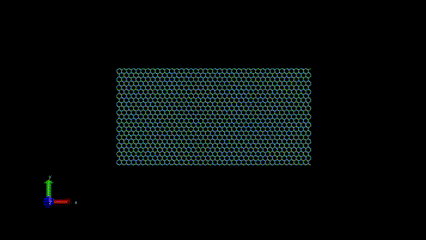

$\quad$ Note que quando o grafeno rasga ele “explode” logo em seguida, isso é devido ao potencial que utilizamos, o Airebo, não há muito na literatura sobre o porquê que isso acontece. Porém, em outros potenciais, por exemplo, o ReaxFF, essa “explosão” não acontece. No entanto, este não consegue descrever tão bem as propriedades mecânicas da amostra como o Airebo [7]. Entretanto, essa “explosão” não altera os resultados cálculos feitos na simulação.

## 4. Determinando o Módulo de Young

$\quad$ Após a simulação estar finalizada podemos determinar o módulo de Young do grafeno com os dados do stress e da deformação. Essas informações estão armazenadas no arquivo `data.dat`. Então, extrairemos a seguir esses dados.

In [13]:
data = np.loadtxt("data.dat", float)
print(data)

[[ 4.02000000e+05  9.99000000e-05 -1.40302421e-04 ...  9.91473564e+01
   5.02628159e+01  4.00000000e+01]
 [ 4.05000000e+05  3.99900000e-04 -1.42168898e-04 ...  9.91770976e+01
   5.02627221e+01  4.00000000e+01]
 [ 4.08000000e+05  6.99900000e-04 -2.55393699e-04 ...  9.92068388e+01
   5.02570303e+01  4.00000000e+01]
 ...
 [ 3.39300000e+06  2.99199900e-01  9.07794537e+05 ...  1.28799368e+02
   4.56347626e+07  4.00000000e+01]
 [ 3.39600000e+06  2.99499900e-01  9.07127739e+05 ...  1.28829110e+02
   4.56012428e+07  4.00000000e+01]
 [ 3.39900000e+06  2.99799900e-01  9.21249478e+05 ...  1.28858851e+02
   4.63111407e+07  4.00000000e+01]]


$\quad$ A primeira coluna desse arquivo é o tempo da simulação, as três colunas seguintes são a deformação do $x$, $y$ e $z$, nessa ordem. Lembre-se de que deformamos o grafeno na direção $x$, assim só nos importará a deformação nessa direção. Observe também que no arquivo `data.dat` foram impressos todas as componentes do tensor pressão, estas são as quantidades de stress nas direções $xx$, $yy$, $zz$, $xy$, $xz$ e $yz$. O que estamos interessados é na primeira componente, a qual é referente ao stress na direção deformada, o $p_{xx}$.

$\quad$ Então, plotaremos o gráfico do Stress $\times$ Strain (deformação).

Text(0, 0.5, 'Stress (GPa)')

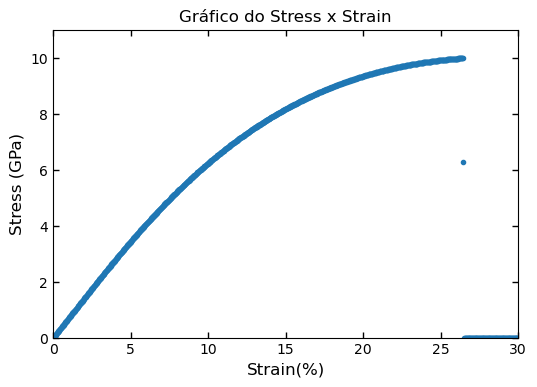

In [14]:
deform = data[:, 1]
stress = data[:, 4]

fig, ax = plt.subplots(figsize=(6, 4))
plt.minorticks_on()
plt.tick_params(axis='both', which='both', top = True, right = True, direction = 'in', length=4, width=1)
plt.xticks(np.arange(0, 30, 5), minor = True)
plt.yticks(np.arange(0, 10, 2), minor = True)

plt.plot(deform*100, stress, ".")

plt.xlim(0, 30)
plt.ylim(0, 11)
plt.title("Gráfico do Stress x Strain", fontsize = 12)
plt.xlabel("Strain(%)", fontsize = 12)
plt.ylabel("Stress (GPa)", fontsize = 12)

$\quad$ Observe que o stress máximo para ruptura do grafeno está muito baixo, na literatura o ideal seria um valor próximo dos $100 \ GPa$. Isso se dá porque esquecemos um passo importante, devemos multiplicar o stress por um parâmetro de correção. Esse fator de correção é a razão entre o comprimento da caixa da dimensão não periódica pelo tamanho real do sistema. Não se engane, quando dizemos “dimensão não periódica”, não estamos falando sobre as paredes da caixa serem periódicas ou não, mas sim se o sistema é periódico ou não naquela dimensão. Esse parâmetro de correção deve ser aplicado, pois o `LAMMPS` divide o stress pelo tamanho da caixa na dimensão não periódica. Caso haja mais de uma dimensão não periódica, o fator de correção tem que ser aplicado em cada uma.

$\quad$ Uma dimensão periódica, a grosso modo, é se o sistema não está isolado dos outros. Na nossa simulação, tivemos que criar um grafeno “infinito” no plano $xy$, ou seja, essas as dimensões $x$ e $y$ são periódicas, mas a $z$ não. Dessa forma, devemos multiplicar o stress com $\frac{L_z}{l_z}$, em que $L_z$ e $l_z$ são o tamanho da caixa e do sistema, respectivamente, na direção $z$. O $l_z$ é a espessura da estrutura, sendo de $3.4 \ Å$. A seguir, esse fator de correção.

In [15]:
boxsize = data[0,12] #tamanho da caixa na dimensão não periódica
stress = stress*(boxsize/3.4)

Text(0, 0.5, 'Stress (GPa)')

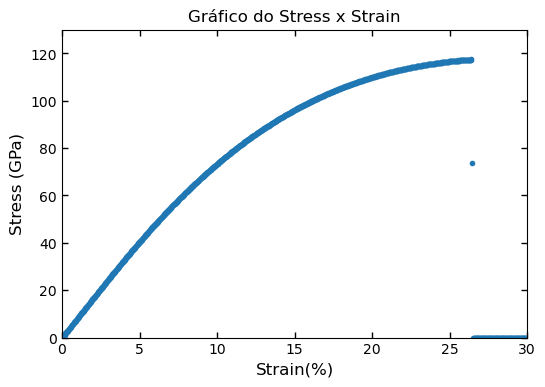

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.minorticks_on()
plt.tick_params(axis='both', which='both', top = True, right = True, direction = 'in', length=4, width=1)
plt.xticks(np.arange(0, 30, 5), minor = True)
plt.yticks(np.arange(0, 120, 20), minor = True)

plt.plot(deform*100, stress, ".")

plt.xlim(0, 30)
plt.ylim(0, 130)
plt.title("Gráfico do Stress x Strain", fontsize = 12)
plt.xlabel("Strain(%)", fontsize = 12)
plt.ylabel("Stress (GPa)", fontsize = 12)

$\quad$ Agora, com o gráfico correto, finalmente podemos determinar o módulo de Young. Analisando a equação para determinar o módulo de Young ($E$), é fácil ver que o $E$ é o coeficiente angular do gráfico do Stress $\times$ Strain. Porém, observe que o stress no gráfico não cresce linearmente em toda a simulação, isso acontece devido às propriedades mecânicas do grafeno, não iremos nos aprofundar nisso neste trabalho. Para resolver isso, é simples, apenas utilizaremos o início do gráfico, porque no início da deformação o stress evolui linearmente.

$\quad$ Para obtermos o coeficiente angular da reta utilizaremos a função `linregress` da biblioteca Scipy. Esse comando recebe os conjuntos domínio e imagem da função que desejamos analisar e retorna o coeficiente angular, ponto de interceptação, coeficiente de correlação de Pearson e entre outros. Então, o comando receberá o intervalo do strain e do stress queremos, retornará o módulo que Young que tantos desejamos.

In [17]:
Mod_Young, b, r_value, p_value, std_err = linregress(deform[20:80], stress[20:80])
print(Mod_Young)

826.2756630890786


$\quad$ Com isso podemos plotar no gráfico essa reta, para termos uma visualização melhor. Para isso, criaremos uma função que retorna uma reta linear. Essa função receberá o eixo $x$, o coeficiente angular ($a$)e a constante ($b$) da reta linear.

In [18]:
def fline(x,a,b):
    return a*x+b

Text(0, 0.5, 'Stress (GPa)')

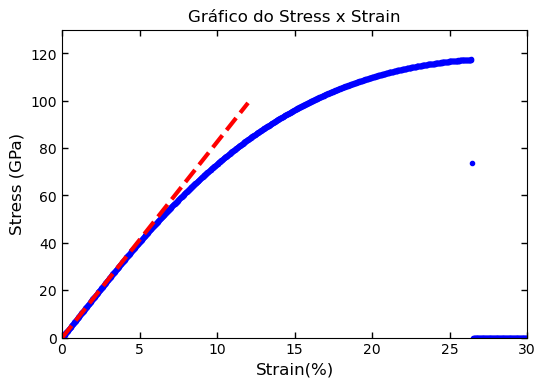

In [19]:
x = np.linspace(0, 0.12, 100)
line = fline(x,Mod_Young,b)

fig, ax = plt.subplots(figsize=(6, 4))
plt.minorticks_on()
plt.tick_params(axis='both', which='both', top = True, right = True, direction = 'in', length=4, width=1)
plt.xticks(np.arange(0, 30, 5), minor = True)
plt.yticks(np.arange(0, 120, 20), minor = True)

plt.plot(deform*100, stress, ".", color = 'b')
plt.plot(x*100, line, color = 'r', lw=3, linestyle= 'dashed')

plt.xlim(0, 30)
plt.ylim(0, 130)

plt.title("Gráfico do Stress x Strain", fontsize = 12)
plt.xlabel("Strain(%)", fontsize = 12)
plt.ylabel("Stress (GPa)", fontsize = 12)

$\quad$ O módulo de Young que obtivemos foi de $826.27 \ GPa$. Este é um ótimo resultado para o método que usamos, dado que o valor esperado para o módulo de Young em MD, com Airebo e um grafeno Armchair é de $828.9 \ GPa$ [7], ou seja, obtivemos um valor bem próximo do esperado. Comparado aos resultados experimentais, essa diferença aumenta, na qual o resultado é aproximadamente $1 \ TPa$ [7].

## 5. Conclusão

$\quad$ Neste trabalho foi apresentado o conceito do módulo de Young, o qual é referente à rigidez de um material. Nosso objetivo era encontrar essa propriedade do grafeno usando Dinâmica Molecular. Para isso, foi necessário fazer uma simulação esticando o grafeno até que o mesmo rasgue, para isso foi necessário utilizar o programa `LAMMPS`. Então, mostramos o passo a passo de como montar um arquivo input e como rodar a simulação.

$\quad$ Feita a simulação, conseguimos obter os dados para determinarmos o módulo de Young do grafeno, o stress e a deformação. Em seguida, foi explicado como utilizar essas informações para determinar tal valor. Então, o módulo de Young obtido foi de $826.27 \ GPa$, utilizando o potencial Airebo. Esse valor é bem próximo dos valores disponíveis na literatura com o mesmo método, com um erro relativo de $0.31 \ \%$. Em outras palavras, o método utilizado nesse `Notebook` está coerente aos utilizados pelos pesquisadores atualmente, de forma que obtivemos um ótimo resultado.

## Agradecimentos

$\quad$ Os resultados desse `Notebook` só foram possível graças ao Núcleo de Processamento de Alto Desempenho da UFRN (NPAD/UFRN). 

---

## Referências

**[1]** OLIVEIRA, J. A. de L. Deformando Nanotubo De Carbono. GitHub. PET - Física, 2023. Disponível em: <https://github.com/PETfisicaUFRN/PET.py/blob/main/Notebooks/Deformando%20nanotubo%20de%20carbono.ipynb>. Acesso em: 29/jun./24.

**[2]** COSTA, M. Da. Módulo De Elasticidade Ou Módulo De Young. Biopdi. 2023. Disponível em: <https://biopdi.com.br/artigos/modulo-de-elasticidade-ou-modulo-de-young/>. Acesso em: jun./29DC.

**[3]** DARAEE, M.; HASSANI, S.; AZAR, S. An Overview of Determination of Young’s modulus by AFM in Various Fields. [s.l.]: [s.n.], [s.d.]. Acesso em: 29/jun./24.

**[4]** RAPAPORT, D. C. The Art of Molecular Dynamics Simulation. [s.l.]: Cambridge University Press, 2004.

**[5]** LAMMPS Documentation (27 Jun 2024 version) — LAMMPS documentation. docs.lammps.org. 2024. Disponível em: <https://docs.lammps.org>. Acesso em: 02/jul./24.

**[6]** THOMPSON, A. et al. LAMMPS - a Flexible Simulation Tool for particle-based Materials Modeling at the atomic, meso, and Continuum Scales. Computer Physics Communications, [s.l.], 2022. DOI: https://doi.org/10.1016/j.cpc.2021.108171.

**[7]** F. Memarian, A. Fereidoon, M. Darvish Ganji, Graphene Young’s modulus: Molecular Mmechanics and DFTTtreatments, Superlattices and Microstructure  (2015), doi: http://dx.doi.org/10.1016/j.spmi
2015.06.01